# Анализ данных для обнаружения мошенничества (Fraud Detection)

В этом ноутбуке проводится анализ признаков, связанных с устройствами пользователей, и создание новых (derived) признаков для улучшения модели CatBoost.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка стиля графиков
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

In [9]:
# Загрузка данных
# Предполагается, что датасет уже загружен в переменную df в предыдущих шагах или загружается здесь
# df = pd.read_csv('path/to/your/data.csv') 

# ⚠️ ЕСЛИ ДАННЫХ НЕТ В ПАМЯТИ, РАСКОММЕНТИРУЙТЕ И УКАЖИТЕ ПУТЬ:
# df = pd.read_csv('../data/processed/dataset_with_features.csv')

df1 = pd.read_csv('../docs/транзакции в Мобильном интернет Банкинге.csv', sep=';', encoding='cp1251', header=1, engine='python')
df2 = pd.read_csv('../docs/поведенческие паттерны клиентов.csv', sep=';', encoding='cp1251', header=1, engine='python')
df = pd.merge(df1, df2, on='cst_dim_id')

# Проверка наличия необходимых колонок
required_cols = ['monthly_os_changes', 'monthly_phone_model_changes', 'last_phone_model_categorical', 'last_os_categorical', 'user_type']
# if not set(required_cols).issubset(df.columns):
#     print("Warning: Not all required columns are present!")

## 1. Базовый анализ признаков устройства (Basic Device Features)

Рассмотрим исходные признаки:
* `monthly_os_changes`: Частота смены ОС.
* `monthly_phone_model_changes`: Частота смены модели телефона.
* `last_phone_model_categorical`: Модель телефона.
* `last_os_categorical`: Версия ОС.

C:\Users\lengway\AppData\Local\Temp\ipykernel_2116\3644346324.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='monthly_os_changes', data=df, palette='Set2', ax=axes[0])
C:\Users\lengway\AppData\Local\Temp\ipykernel_2116\3644346324.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='target', y='monthly_phone_model_changes', data=df, palette='Set2', ax=axes[1])


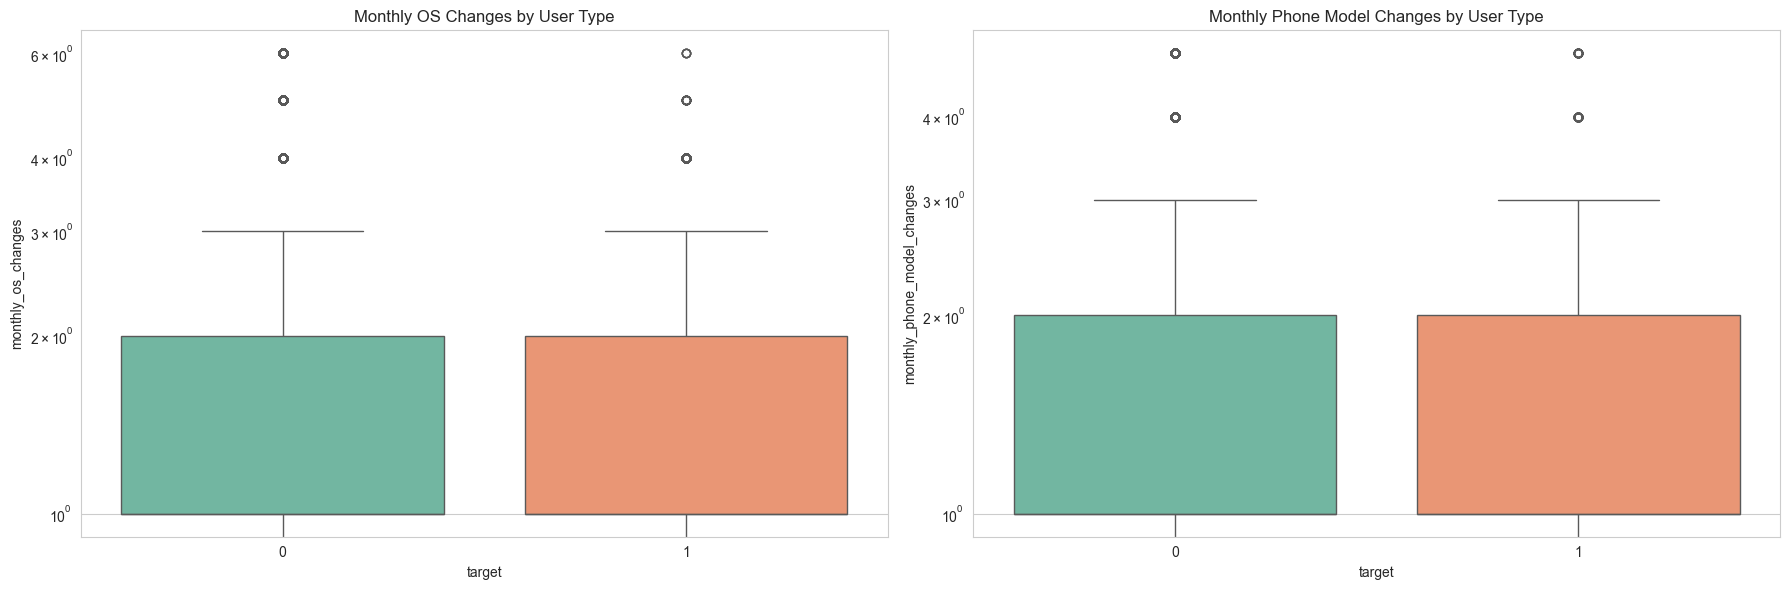

📊 Статистика по базовым признакам:
       monthly_os_changes                                               \
                    count      mean       std  min  25%  50%  75%  max   
target                                                                   
0                772929.0  1.450255  0.747195  0.0  1.0  1.0  2.0  6.0   
1                  4969.0  1.488831  0.787844  0.0  1.0  1.0  2.0  6.0   

       monthly_phone_model_changes                                          \
                             count      mean       std  min  25%  50%  75%   
target                                                                       
0                         772929.0  1.359064  0.614110  0.0  1.0  1.0  2.0   
1                           4969.0  1.428658  0.671924  0.0  1.0  1.0  2.0   

             
        max  
target       
0       5.0  
1       5.0  


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot для смены ОС
sns.boxplot(x='target', y='monthly_os_changes', data=df, palette='Set2', ax=axes[0])
axes[0].set_title('Monthly OS Changes by User Type')
axes[0].set_yscale('log') # Логарифмическая шкала для выбросов

# Boxplot для смены модели телефона
sns.boxplot(x='target', y='monthly_phone_model_changes', data=df, palette='Set2', ax=axes[1])
axes[1].set_title('Monthly Phone Model Changes by User Type')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

print("📊 Статистика по базовым признакам:")
print(df.groupby('target')[['monthly_os_changes', 'monthly_phone_model_changes']].describe())

## 2. Продвинутый Feature Engineering (Advanced Derived Features)

Создаем мощные производные признаки для CatBoost, чтобы выявить сложные паттерны мошенничества.

### Список новых признаков:
1. **`device_stability_score`**: Суммарная частота изменений (ОС + Модель).
2. **`device_volatility_index`**: Взвешенная сумма изменений (смена модели весит больше).
3. **`os_change_flag`** & **`model_change_flag`**: Бинарные флаги изменений.
4. **`high_device_volatility`**: Флаг высокой нестабильности.
5. **`rare_device_flag`**: Флаг редкого устройства (используется < 1% пользователей).
6. **`rare_os_flag`**: Флаг редкой ОС.
7. **`interaction_change_flags`**: Взаимодействие флагов смены (сменил И то, И другое).
8. **`suspicious_device_combo`**: Комбинация редкого устройства и высокой волатильности.
9. **`os_model_combo`**: Текстовая комбинация ОС и модели (для CatBoost).

In [12]:
# 1. Device Stability Score (Сумма изменений)
df['device_stability_score'] = df['monthly_os_changes'] + df['monthly_phone_model_changes']

# 2. Device Volatility Index (Взвешенная сумма, смена модели более подозрительна)
df['device_volatility_index'] = (df['monthly_phone_model_changes'] * 2) + df['monthly_os_changes']

# 3. Binary Flags
df['os_change_flag'] = (df['monthly_os_changes'] > 0).astype(int)
df['model_change_flag'] = (df['monthly_phone_model_changes'] > 0).astype(int)

# 4. High Volatility Flag (Порог можно настроить, например, >= 2 изменений)
df['high_device_volatility'] = (df['device_stability_score'] >= 2).astype(int)

# 5. Rare Device Flag (Frequency Encoding logic)
# Считаем редкими те модели, которые встречаются у менее чем 1% пользователей (или порог N)
device_counts = df['last_phone_model_categorical'].value_counts(normalize=True)
rare_threshold = 0.01 # 1%
df['rare_device_flag'] = df['last_phone_model_categorical'].map(lambda x: 1 if device_counts.get(x, 0) < rare_threshold else 0)

# 6. Rare OS Flag
os_counts = df['last_os_categorical'].value_counts(normalize=True)
df['rare_os_flag'] = df['last_os_categorical'].map(lambda x: 1 if os_counts.get(x, 0) < rare_threshold else 0)

# 7. Interaction: Changed BOTH OS and Model
df['interaction_change_flags'] = df['os_change_flag'] * df['model_change_flag']

# 8. Suspicious Combo: High Volatility + Rare Device
# Редкое устройство, которое часто меняется/перепрошивается - сильный сигнал
df['suspicious_device_combo'] = df['high_device_volatility'] * df['rare_device_flag']

# 9. Categorical Combo (для CatBoost)
df['os_model_combo'] = df['last_os_categorical'].astype(str) + "_" + df['last_phone_model_categorical'].astype(str)

print("✅ Продвинутые признаки успешно созданы.")

✅ Продвинутые признаки успешно созданы.


## 3. Визуализация и анализ новых признаков

Посмотрим, как новые признаки различаются для мошенников (Fraud) и обычных пользователей (Non-Fraud).

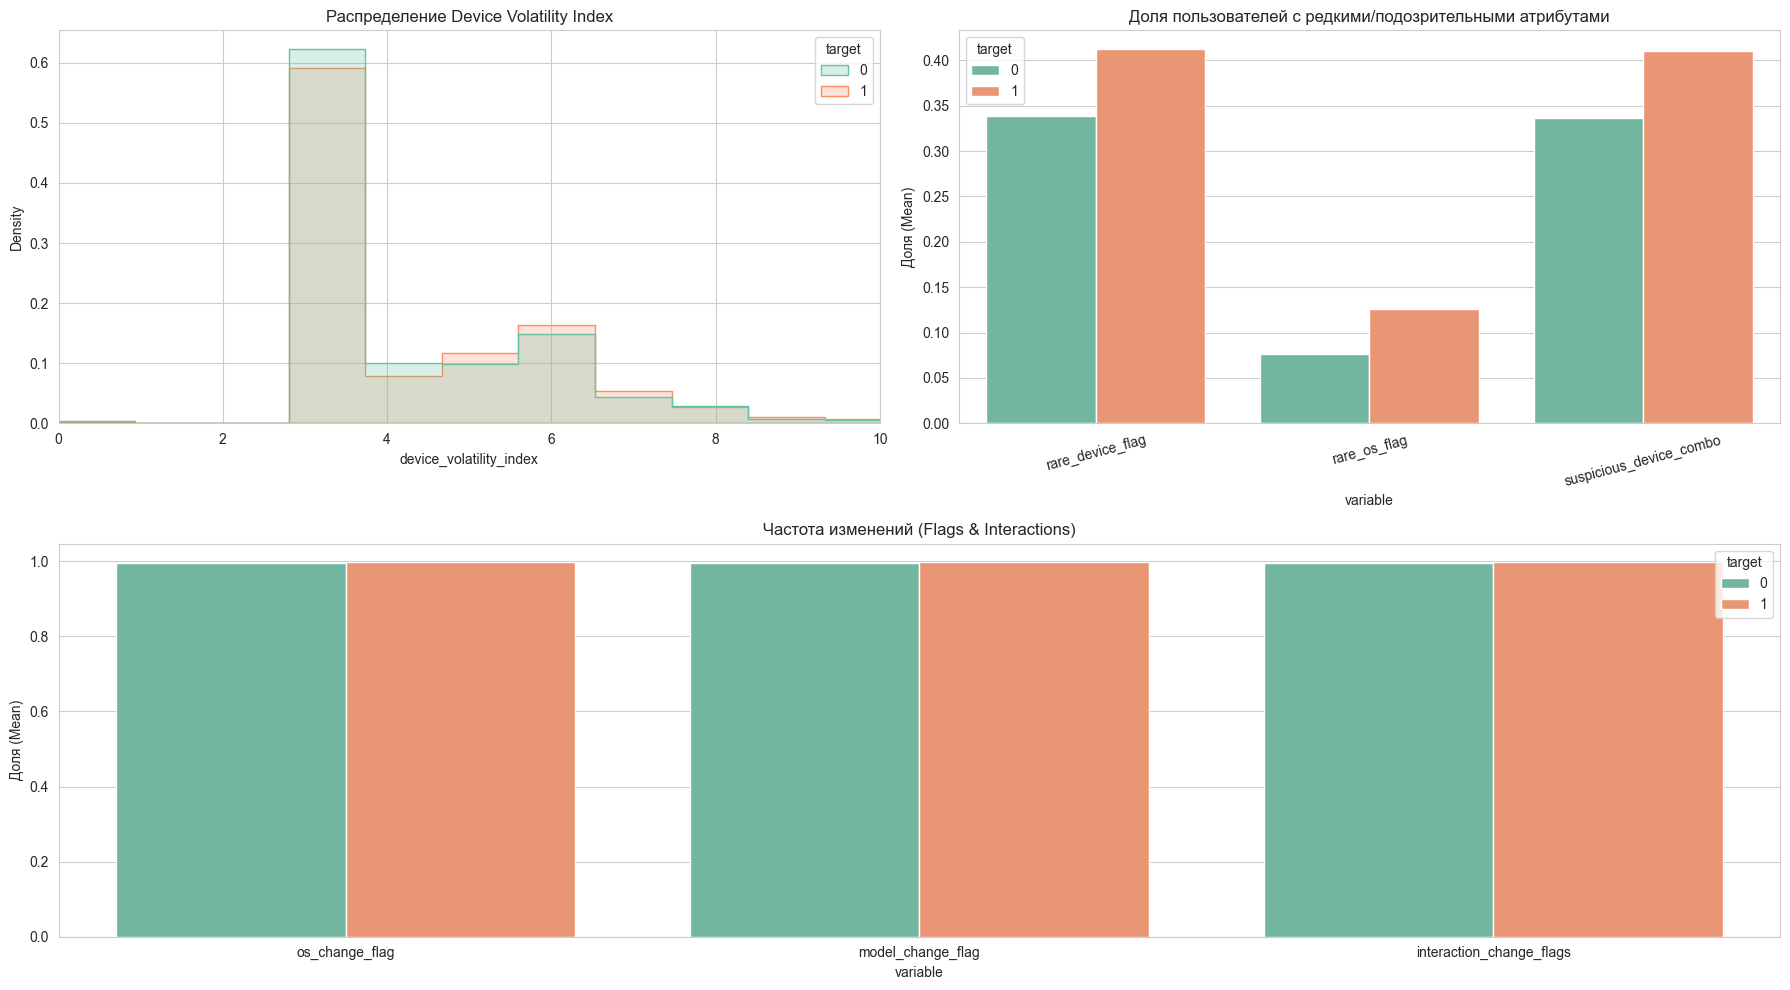

In [13]:
plt.figure(figsize=(18, 10))

# 1. Device Volatility Index (KDE Plot)
plt.subplot(2, 2, 1)
sns.histplot(data=df, x='device_volatility_index', hue='target', element="step", stat="density", common_norm=False, palette='Set2', bins=15)
plt.title('Распределение Device Volatility Index')
plt.xlim(0, 10)

# 2. Rare Flags Analysis
rare_cols = ['rare_device_flag', 'rare_os_flag', 'suspicious_device_combo']
rare_data = df.groupby('target')[rare_cols].mean().reset_index().melt(id_vars='target')

plt.subplot(2, 2, 2)
sns.barplot(x='variable', y='value', hue='target', data=rare_data, palette='Set2')
plt.title('Доля пользователей с редкими/подозрительными атрибутами')
plt.ylabel('Доля (Mean)')
plt.xticks(rotation=15)

# 3. Interaction Flags
interaction_cols = ['os_change_flag', 'model_change_flag', 'interaction_change_flags']
inter_data = df.groupby('target')[interaction_cols].mean().reset_index().melt(id_vars='target')

plt.subplot(2, 1, 2)
sns.barplot(x='variable', y='value', hue='target', data=inter_data, palette='Set2')
plt.title('Частота изменений (Flags & Interactions)')
plt.ylabel('Доля (Mean)')

plt.tight_layout()
plt.show()

In [23]:
fraud_users = df[df['target'] == 1]['cst_dim_id'].unique()
non_fraud_users = df[df['target'] == 0]['cst_dim_id'].unique()

print("Number of Fraud Users:", len(fraud_users))
print("Number of Non-Fraud Users:", len(non_fraud_users))

Number of Fraud Users: 107
Number of Non-Fraud Users: 331


In [25]:
# Список фичей, которые хочешь анализировать
all_device_features = [
    'monthly_os_changes', 'monthly_phone_model_changes',
    'device_stability_score', 'device_volatility_index',
    'os_change_flag', 'model_change_flag', 'interaction_change_flags',
    'rare_device_flag', 'rare_os_flag', 'suspicious_device_combo'
]

# 1) Убедимся, что все фичи есть (иначе уберём отсутствующие)
present_features = [f for f in all_device_features if f in df.columns]
missing = [f for f in all_device_features if f not in df.columns]
if missing:
    print("Внимание — нет колонок:", missing)
print("Будем использовать фичи:", present_features)

# 2) Группировка по target и усреднение
summary_table = df.groupby('target')[present_features].mean().T
# После transpose колонки — это значения target (0 и 1)
print("Колонки summary_table (должны быть 0 и 1):", summary_table.columns.tolist())

# 3) Чтобы не гадать: явные имена для fraud/non-fraud
# Если в твоём таргете 1 = fraud и 0 = non-fraud:
if 1 in summary_table.columns and 0 in summary_table.columns:
    summary_table = summary_table.rename(columns={1: 'fraud_mean', 0: 'nonfraud_mean'})
else:
    # fallback: взять как строки в порядке unique(df['target'])
    cols = summary_table.columns.tolist()
    if len(cols) == 2:
        summary_table = summary_table.rename(columns={cols[0]: 'nonfraud_mean', cols[1]: 'fraud_mean'})
    else:
        # если только одна из групп есть — обработаем аккуратно
        if 1 in summary_table.columns:
            summary_table = summary_table.rename(columns={1: 'fraud_mean'})
        if 0 in summary_table.columns:
            summary_table = summary_table.rename(columns={0: 'nonfraud_mean'})

# 4) Добавим колонку Diff_Ratio = fraud / nonfraud (защитимся от деления на ноль)
summary_table['Diff_Ratio'] = summary_table.get('fraud_mean', 0) / (summary_table.get('nonfraud_mean', 0) + 1e-9)

# 5) Для удобства добавим counts по группам (coverage)
counts = df['target'].value_counts()
summary_table['count_fraud'] = int(counts.get(1, 0))
summary_table['count_nonfraud'] = int(counts.get(0, 0))

# 6) Вывод отсортированного результата
print("\n📋 Сводная таблица по Device-признакам (средние значения и отношение Fraud/Non-Fraud):")
display(summary_table.sort_values('Diff_Ratio', ascending=False))


Будем использовать фичи: ['monthly_os_changes', 'monthly_phone_model_changes', 'device_stability_score', 'device_volatility_index', 'os_change_flag', 'model_change_flag', 'interaction_change_flags', 'rare_device_flag', 'rare_os_flag', 'suspicious_device_combo']
Колонки summary_table (должны быть 0 и 1): [0, 1]

📋 Сводная таблица по Device-признакам (средние значения и отношение Fraud/Non-Fraud):


target,nonfraud_mean,fraud_mean,Diff_Ratio,count_fraud,count_nonfraud
rare_os_flag,0.076888,0.125579,1.633265,4969,772929
suspicious_device_combo,0.336877,0.410747,1.219278,4969,772929
rare_device_flag,0.338277,0.412357,1.218991,4969,772929
monthly_phone_model_changes,1.359064,1.428658,1.051207,4969,772929
device_volatility_index,4.168383,4.346146,1.042646,4969,772929
device_stability_score,2.809319,2.917488,1.038504,4969,772929
monthly_os_changes,1.450255,1.488831,1.026599,4969,772929
os_change_flag,0.996764,0.997585,1.000823,4969,772929
model_change_flag,0.996764,0.997585,1.000823,4969,772929
interaction_change_flags,0.996764,0.997585,1.000823,4969,772929


In [ ]:
print("\n🔍 Топ-10 самых частых комбинаций 'OS + Model' среди мошенников:")
print(df[df['target'] == '1']['os_model_combo'].value_counts().head(10))

print("\n🔍 Топ-10 самых частых комбинаций 'OS + Model' среди обычных пользователей:")
print(df[df['target'] == '0']['os_model_combo'].value_counts().head(10))


🔍 Топ-10 самых частых комбинаций 'OS + Model' среди мошенников:
Series([], Name: count, dtype: int64)

🔍 Топ-10 самых частых комбинаций 'OS + Model' среди обычных пользователей:
Series([], Name: count, dtype: int64)


: 